In [509]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle as pkl
import torch.autograd as autograd
import torch.nn as nn
import os
import math
import random
import gensim
import nltk
import random
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import enchant
import matplotlib.pyplot as plt
from nltk import WordNetLemmatizer, word_tokenize, bigrams, ngrams, RegexpTokenizer
lemmatize = WordNetLemmatizer()
%matplotlib inline

In [867]:
class recsys(nn.Module):
    
    
    def __init__(self,ratings=None,users=100,sites=1000,latent_features=10,dropout=.1,max_iter=10,epochs=4,temperature=1,losses=None):
        
        super(recsys,self).__init__()
        
        self.users=users
        self.sites=sites
        self.dropout=nn.Dropout(p=dropout)
        self.max_iter=max_iter
        self.temperature=temperature
        self.ratings=ratings
        self.losses=None
        self.epochs=epochs
        self.linear1=nn.Linear(sites,latent_features)
        self.linear2=nn.Linear(latent_features,latent_features)
        self.linear3=nn.Linear(latent_features,sites)
    
    
    # The input x should have shape (number_of_users,sites)
    # Ratings needs to be a torch tensor of the same shape as x.
    
    
#     def get_mask(self,ratings=None):

#         try: 
#             if ratings==None:
#                 pass
#         except:
#             self.ratings=ratings
            
#         mask=[]
#         for i in range(len(self.ratings)):
#             mask.append([0 if math.isnan(self.ratings[i,j]) else 1 for j in range(len(self.ratings[0]))])
#         return torch.tensor(mask)
       
    
    
    def imputer(self,x=None):
        #Need to make a function which takes in a ratings array and returns
        #an initial best guess.  For now I'll just mask the unkown variables
        #print(type(self.ratings))
        
        try: 
            if x==None:
                ratings=self.ratings
        except:
            ratings=x      
                
        ratings[np.isnan(ratings)] = 0
        return torch.tensor(ratings).float()
    

    
    def forward(self,x):
        x=self.imputer(x)
        x=self.linear1(x.float())
        x=torch.tanh(x)
        x=self.linear2(x.float())
        x=self.dropout(x.float())
        x=torch.tanh(x)
        x=self.linear3(x.float())
        return x
    
    
    def custom_loss(self,x,y):
        ct=0
        for i in range(len(x)):
            ct+=1-(x[i]@y[i])/(torch.norm(x[i])*torch.norm(y[i]))
        return ct/len(x)


    
    def predict(self,x):
        x=self.imputer(x)
        return self.forward(x)
    
    def fit(self,ratings=None):
        
        try: 
            if ratings==None:
                ratings=self.ratings
        except:
            pass            

        ratings_clean=self.imputer(ratings)

        loss_function=nn.MSELoss()
    
        optimizer = optim.Adam(self.parameters(),lr=.01)


        f= open('data/losses','w+')

        losses=[]

        for i in range(1,self.epochs+1):
            
            for _ in range(self.max_iter):
                optimizer.zero_grad()
                out = self.forward(ratings_clean)
                #loss = loss_function(out,ratings_clean) #This one works!
                loss = self.custom_loss(out,ratings_clean)  #This one works
                losses.append(float(loss.detach().numpy()))
                f.write(str(loss.detach().numpy())+',')
                loss.backward(retain_graph=True)
                
                optimizer.step()
            self.losses=losses
        f.close()

In [868]:
test=recsys(users=100,sites=1000,latent_features=20,dropout=0,epochs=5,max_iter=10)


In [869]:
data=[]
users=100
sites=1000
ranked=30
for j in range(users):
    ra=np.random.choice(range(users),ranked)
    data.append(np.array([10*random.random() if (i in ra) else float('NaN') for i in range(sites)]))
data=np.array(data)

In [870]:
test.fit(data)

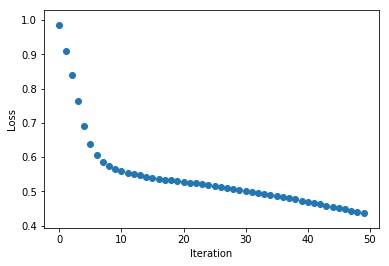

In [872]:
plt.scatter(list(range(len(test.losses))),test.losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [873]:
predictions=test.predict(data[2])